In [5]:
from src import utils
import os

annotations_path = os.path.join(utils.DATA_PATH, "raw", "annotations.csv")
images_path = os.path.join(utils.DATA_PATH, "raw", "images")

In [6]:
import pandas as pd
import cv2
import numpy as np
from src.features.dataset import ImagesDatasetGenerator 
import tensorflow as tf

annotations = pd.read_csv(annotations_path)

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(16)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

dataset_generator = ImagesDatasetGenerator(
  images_path = images_path,
  annotations = annotations
)

dataset = tf.data.Dataset.from_generator(
    dataset_generator.get_image,
    output_signature=(tf.TensorSpec(shape=(512, 512, 3)), tf.TensorSpec(shape=(4, )))
)

dataset = configure_for_performance(dataset)


tf.Tensor(
[[[255. 253. 252.]
  [255. 253. 252.]
  [255. 252. 251.]
  ...
  [ 92. 115. 105.]
  [107. 126. 117.]
  [115. 132. 123.]]

 [[255. 254. 253.]
  [254. 252. 251.]
  [251. 248. 247.]
  ...
  [113. 134. 124.]
  [127. 144. 136.]
  [135. 150. 141.]]

 [[255. 255. 254.]
  [251. 250. 249.]
  [242. 240. 239.]
  ...
  [155. 171. 163.]
  [167. 181. 173.]
  [174. 186. 178.]]

 ...

 [[ 81.  95. 113.]
  [ 79.  93. 110.]
  [ 73.  88. 105.]
  ...
  [171. 172. 182.]
  [169. 170. 180.]
  [168. 169. 179.]]

 [[ 86. 100. 118.]
  [ 79.  93. 111.]
  [ 65.  79.  97.]
  ...
  [170. 171. 181.]
  [176. 177. 187.]
  [179. 180. 190.]]

 [[ 88. 102. 120.]
  [ 79.  93. 111.]
  [ 61.  75.  93.]
  ...
  [170. 171. 181.]
  [179. 180. 190.]
  [184. 185. 195.]]], shape=(512, 512, 3), dtype=float32)


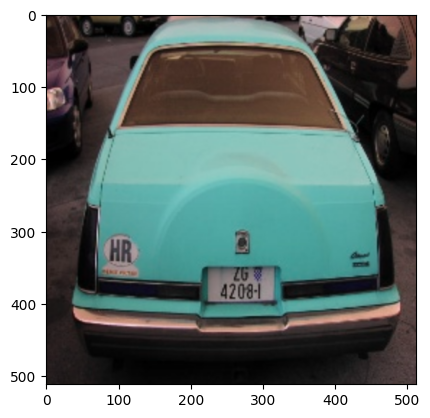

In [13]:
from src.visualization.image_visualizer import show_image
from shapely.geometry import box

# FIX ANNOTATIONW ORDER
sample = list(dataset.take(1))[0][0]
image = sample[0]
annotation = sample[1]
print(annotation)
show_image(image.numpy().astype(np.uint8))

In [14]:
import mlflow
from src.models.model_trainer import train_model
from src.models.get_model import get_model 

MODEL_NAME = "hope"

model = get_model(
    "raw_model",
    1
)

ERROR:root:Could not find registered model with name raw_model
Traceback (most recent call last):
  File "/home/gianfranco/Desktop/uni/plate-recognition/src/models/get_model.py", line 18, in get_model
    model = mlflow.tensorflow.load_model(model_version_uri)
  File "/home/gianfranco/Desktop/uni/ml-boilerplate/venv/lib/python3.8/site-packages/mlflow/tensorflow/__init__.py", line 602, in load_model
    local_model_path = _download_artifact_from_uri(artifact_uri=model_uri, output_path=dst_path)
  File "/home/gianfranco/Desktop/uni/ml-boilerplate/venv/lib/python3.8/site-packages/mlflow/tracking/artifact_utils.py", line 100, in _download_artifact_from_uri
    return get_artifact_repository(artifact_uri=root_uri).download_artifacts(
  File "/home/gianfranco/Desktop/uni/ml-boilerplate/venv/lib/python3.8/site-packages/mlflow/store/artifact/artifact_repository_registry.py", line 106, in get_artifact_repository
    return _artifact_repository_registry.get_artifact_repository(artifact_uri)
  Fi

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 511, 511, 32)      416       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 511, 511, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 510, 510, 32)      4128      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 510, 510, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 509, 509, 32)      4128      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 509, 509, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 254, 254, 32)     0

In [15]:
with mlflow.start_run():
    
    # Automatically capture the model's parameters, metrics, artifacts,
    # and source code with the `autolog()` function
    mlflow.tensorflow.autolog()

    train_model(
        model = model, 
        dataset = dataset,
        #validation_split = 0.2,
        #validation_dataset=validation_set,
        model_name=MODEL_NAME
    )


Epoch 1/1000
     28/Unknown - 69s 2s/step - loss: 7374.3584 - root_mean_squared_error: 85.8741 - iou: 11.9193

Successfully registered model 'hope'.
2023/01/04 20:58:02 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: hope, version 1


28/28 [==============================] - 70s 2s/step - loss: 7374.3584 - root_mean_squared_error: 85.8741 - iou: 11.9193
Epoch 2/1000


Created version '1' of model 'hope'.


21/28 [=====================>........] - ETA: 17s - loss: 792.0117 - root_mean_squared_error: 28.1427 - iou: 0.3217

KeyboardInterrupt: 